In [8]:
from htrc_features import FeatureReader
import numpy as np
import pandas as pd

In [74]:
def get_htrc_page_data(document):
    fr = FeatureReader([document])
    vol = next(fr.volumes())
#     ptc = vol.tokenlist(pos=False, case=False).reset_index().drop(['section'], axis=1)
    ptc = vol.tokenlist(pos=True, case=False).reset_index().drop(['section'], axis=1)
    ptc = ptc[ptc["pos"]=="NN"]
# make it only grab the pos you're interested in- either go into ht or make new cell, vol=
    page_list = set(ptc['page'])
    
    # extract tokens by page 
    tokens=list()
    for page in page_list:
        page_data = str()
        
        # operate on each token
        for page_tokens in ptc.loc[ptc['page'] == page].iterrows():
            if page_tokens[1][1].isalpha():
                
                # deal with frequency count by creating correct number of tokens
                page_data += (' '.join([page_tokens[1][1]] * page_tokens[1][3])) + " "

        tokens.append(page_data.split())
    return tokens

In [75]:
fr = FeatureReader(["mdp.39015038888775"])
vol = next(fr.volumes())
ptc = vol.tokenlist(pos=True, case=False).reset_index().drop(['section'], axis=1)

In [76]:
ptc= ptc[ptc["pos"]=="NN"]
page_list = set(ptc['page'])

# extract tokens by page 
tokens=list()
for page in page_list:
    page_data = str()

    # operate on each token
    for page_tokens in ptc.loc[ptc['page'] == page].iterrows():
        print(page_tokens[1][3])
#         if page_tokens[1][1].isalpha():
#             page_data += (' '.join([page_tokens[1][1]] * page_tokens[1][2])) + " "


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
10
1
1
1
2
1
1
1
1
11
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
4
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
2
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
2
1
1
3
1
1
1
1
2
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
5
1
3
1
1
2
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
2
4
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
2
1
2
1
2
2
1
1
1
1
1
1
1
1
3
2
2
1
2
1
1
3
1
1
1
3
2
1
1
2
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
2
2
1
2
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
2
1
1
1
2
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1


1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
9
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
4
2
1
2
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
2
1
2
1
1
1
1
1
2
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
3
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
7


1
1
1
1
1
1
1
5
1
1
1
2
1
1
1
1
1
1
3
1
1
1
1
1
1
1
2
2
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
2
1
1
1
1
1
2
1
1
2
2
4
3
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
2
1
1
1
3
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
3
1
3
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
1
1
2
1
1
1
2
1
1
2
1
1
2
1
1
1
1
2
1
1
3
1
1
1
1
1
1
1
1


1
1
1
1
1
3
1
1
1
1
1
2
2
1
1
1
1
1
1
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
2
1
1
2
1
1
1
2
1
1
1
2
1
2
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
4
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
3
1
2
1
1
1
1
1
5
2
1
1
1
1
1
3
2
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
2
1
1
1
1
2
1
1
3
1
1
2
1
1
1
1


In [77]:
# return bibliographic data
def get_htrc_metadata(document):
    fr = FeatureReader([document])
    vol = next(fr.volumes())
    return([vol.author[0],vol.title,vol.year])

In [83]:
# htids for two classes 
hard_sf = ["mdp.39015038888775", "pst.000027847633", "mdp.39015013517985", "mdp.39015020680461", "mdp.39015020690858", "pst.000029273768", "mdp.39015013433738", "mdp.39015013534014", "mdp.39015012435791", "pst.000059688501"]
soft_sf = ["mdp.39015020645456", "mdp.39015003922005", "mdp.39015000244775", "mdp.39015047597136",  "mdp.49015000529041",  "mdp.49015003071447", "inu.30000004080028", "mdp.39015005320745", "mdp.39015054037372", "pst.000011824909"]
#"ppt.ssfcbz201710000391", "uiug.30112077272364", "ppt.ssfcbz201710000347",
# "pst.000011824909", "mdp.39015005320745", "uiug.30112061864242"

In [84]:
all_texts = hard_sf + soft_sf

In [85]:
# create labels for classifier
labels = ["hard"] * len(hard_sf) + ["soft"] * len(soft_sf)

In [86]:
# construct text for consumption into dtm
raw_data = list()
for doc in hard_sf + soft_sf:
    page_data = get_htrc_page_data(doc)
    tokens = ' '.join([w for p in page_data for w in p])
    raw_data.append(tokens)

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(input='content',
                             stop_words='english',
                             strip_accents='unicode')

In [88]:
dtm = vec.fit_transform(raw_data)

In [89]:
dtm.shape
# large sparse matrix: 17,41229

(20, 15182)

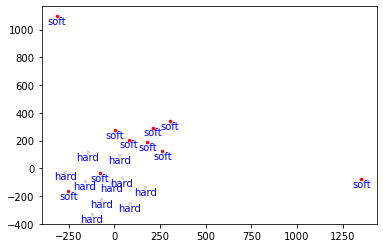

In [90]:
# T-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# fig = plt.figure(figsize=(35, 20), dpi=75)
plot = TSNE(n_components=2, learning_rate='auto',
            init='random', 
            perplexity=3).fit_transform(dtm)

for x, y, label,htid in zip(plot[:,0], plot[:,1], labels,all_texts):
    if label == "hard":
        plt.scatter(x, y, c='lightgrey',s=6)
    else:
        plt.scatter(x, y, c='red',s=6)
    plt.text(x, y, label, c='blue', ha='center', va='top')

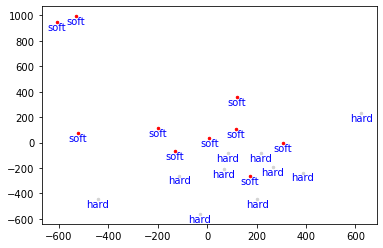

In [91]:
# MDS

# fig = plt.figure(figsize=(35, 20), dpi=75)

from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=1)
plot = mds.fit_transform(dtm.toarray())
for x, y, label,htid in zip(plot[:,0], plot[:,1], labels,all_texts):
    if label == "hard":
        plt.scatter(x, y, c='lightgrey',s=6)
    else:
        plt.scatter(x, y, c='red',s=6)
    plt.text(x, y, label, c='blue', ha='center', va='top')

In [92]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

clf = SGDClassifier(tol=None,max_iter=1000,random_state=42).fit(dtm,labels)

<AxesSubplot:title={'center':'Key Features: Hard'}>

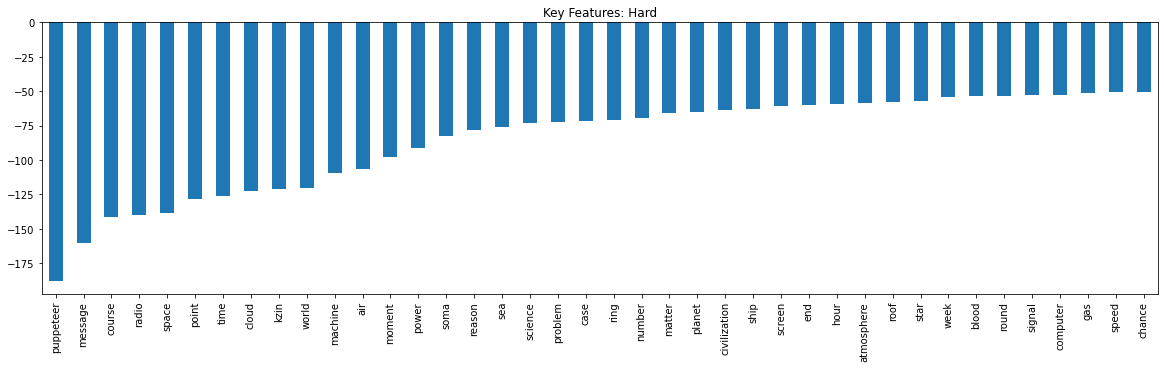

In [93]:
df = pd.DataFrame([clf.coef_[0][idx] for idx in np.argsort(clf.coef_[0])[:40]],
                  index = [vec.get_feature_names_out()[idx] for idx in np.argsort(clf.coef_[0])[:40]])
df.plot(figsize=(20, 5),kind='bar',title='Key Features: Hard',legend=False)

# would be interesting to remove things like character names/spec pos tags 
# expand collections 
# semantic meaning: presence of word/repetitions

<AxesSubplot:title={'center':'Key Features: Soft'}>

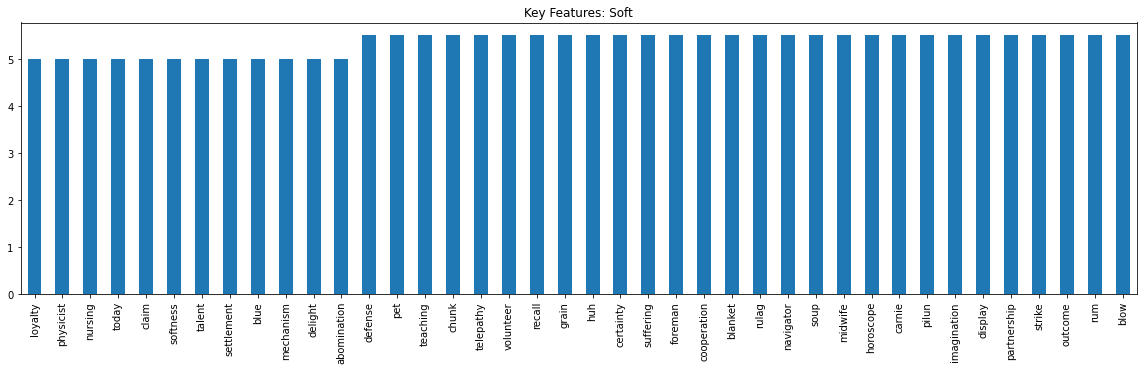

In [73]:
df = pd.DataFrame([clf.coef_[0][idx] for idx in np.argsort(clf.coef_[0])[14656-40:14656]],
                  index = [vec.get_feature_names_out()[idx] for idx in np.argsort(clf.coef_[0])[14656-40:14656]])
df.plot(figsize=(20, 5),kind='bar',title='Key Features: Soft',legend=False)

In [49]:
np.argsort(clf.coef_[0])[41229-40:41229]
# term frequency inverse document frequency--> become scaled values instead of frequency values

array([], dtype=int64)

In [50]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity
cosine_dist_matrix = 1 - cosine_similarity(dtm)

%timeit
affprop = AffinityPropagation(random_state=None,affinity="precomputed", max_iter=1000, damping=0.99)
affprop.fit(cosine_dist_matrix)

AffinityPropagation(affinity='precomputed', damping=0.99, max_iter=1000)

In [51]:
# Display clusters
for cluster in np.unique(affprop.labels_):
    print(cluster," ".join(np.array(labels)[(affprop.labels_ == cluster)]))

0 hard hard hard hard hard hard hard hard hard hard soft soft soft soft soft soft soft soft
